In [4]:
#%% Libraries import
import sys  
sys.path.insert(1, '/Users/skardova/Dropbox/Lungs/HiDeNN_1D/hidenn_1d')

from HiDeNN_PDE import MeshNN, NeuROM, MeshNN_2D, MeshNN_1D
# Import pre-processing functions
import Bin.Pre_processing as pre
# Import torch librairies
import torch
import torch.nn as nn
# Import Training funcitons
from Bin.Training import Training_1D_FEM_LBFGS, Training_1D_Mixed_LBFGS
#Import post processing libraries
import Post.Plots as Pplot
import time
import os
import torch._dynamo as dynamo
mps_device = torch.device("mps")
from importlib import reload  # Python 3.4+
import tomllib
import numpy as numpy
import argparse



In [14]:
# Load default configuration file (defines dimension, domain, boundary conditions, number of training iterations etc.)
Default_config_file = '/Users/skardova/Dropbox/Lungs/HiDeNN_1D/hidenn_1d/Configuration/config_1D.toml'

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('-cf',type=str, help = 'path to the desired configuration file', default=Default_config_file, action = 'store')
    
    args, unknown = parser.parse_known_args()

    inputs = vars(args)
    print(f"* Executing job in {args.cf}")

with open(args.cf, mode="rb") as f:
    config = tomllib.load(f)

* Executing job in /Users/skardova/Dropbox/Lungs/HiDeNN_1D/hidenn_1d/Configuration/config_1D.toml


In [15]:
# Experiment setting: Potential energy loss
# 6 mesh resolutions, 5-point quadrature 

mesh_resolution_pe = [10,21,41,80,160]
loss_u_pe = numpy.zeros((len(mesh_resolution_pe)))
loss_grad_pe = numpy.zeros((len(mesh_resolution_pe)))

config["interpolation"]["n_integr_points"] = 5
config["solver"]["IntegralMethod"] = "Gaussian_quad"
config["solver"]["FrozenMesh"] = True

for res in range(len(mesh_resolution_pe)):

    config["interpolation"]["np"] = mesh_resolution_pe[res]
    

    # Load parameters
    Mat = pre.Material(     flag_lame = True,                          # If True should input lmbda and mu instead of E and nu
                            coef1     = config["material"]["E"],        # Young Modulus
                            coef2     = config["material"]["A"]        # Poisson's ratio
                        )

    MaxElemSize = pre.ElementSize(
                                    dimension     = config["interpolation"]["dimension"],
                                    L             = config["geometry"]["L"],
                                    order         = config["interpolation"]["order"],
                                    np            = config["interpolation"]["np"],
                                )

    Excluded = []

    Mesh_object = pre.Mesh( 
                                    config["geometry"]["Name"],                 # Create the mesh object
                                    MaxElemSize, 
                                    config["interpolation"]["order"], 
                                    config["interpolation"]["dimension"]
                            )

    Mesh_object.AddBorders(config["Borders"]["Borders"])
    Mesh_object.AddBCs(                                                         # Include Boundary physical domains infos (BCs+volume)
                                    config["geometry"]["Volume_element"],
                                    Excluded,
                                    config["DirichletDictionryList"]
                        )                   

    Mesh_object.MeshGeo()                                                       # Mesh the .geo file if .msh does not exist
    Mesh_object.ReadMesh() 

    print(config["solver"]["IntegralMethod"])
    print()
    # Vtk file not necessary if not using reference element implementation
    if config["solver"]["IntegralMethod"] == "Gaussian_quad":
        Mesh_object.ExportMeshVtk1D()

    # Build the assembly weight matrix if needed
    if config["interpolation"]["dimension"] ==1 and config["solver"]["IntegralMethod"] == "Trapezoidal":
        Mesh_object.AssemblyMatrix()                                            

    if int(Mesh_object.dim) != int(Mesh_object.dimension):
        raise ValueError("The dimension of the provided geometry does not match the job dimension")

    if config["solver"]["TrainingStrategy"]=="Integral":
        match config["solver"]["IntegralMethod"]:                          
            case "Gaussian_quad":
                Model_FEM = MeshNN_1D(Mesh_object, config["interpolation"]["n_integr_points"])  
            case "Trapezoidal":
                Model_FEM = MeshNN(Mesh_object)

    if config["solver"]["TrainingStrategy"]=="Mixed":
        if config["solver"]["IntegralMethod"] == "Gaussian_quad":
            Model_FEM = MeshNN_1D(Mesh_object, config["interpolation"]["n_integr_points"])
            Model_test = MeshNN_1D(Mesh_object, config["interpolation"]["n_integr_points"])  
            Model_test.Freeze_Mesh()

    # Default setting
    Model_FEM.Freeze_Mesh()
    Model_FEM.UnFreeze_FEM()

    if not config["solver"]["FrozenMesh"]:
        Model_FEM.UnFreeze_Mesh()    

    if config["solver"]["TrainingStrategy"]=="Mixed":
        Model_FEM = Training_1D_FEM_LBFGS(Model_FEM, config, Mat, Model_test)
    else:
        Model_FEM = Training_1D_FEM_LBFGS(Model_FEM, config, Mat)

    loss_u_pe[res], loss_grad_pe[res] = Pplot.Normalized_error_1D(Model_FEM,config,Mat)



 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       9
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  10
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  -0.01360793404964395
     loss_decrease =  1.013607934049644
epoch =  2
     loss =  -0.01360793404964395
     loss_decrease =  0.0
epoch =  3
     loss =  -0.01360793404964395
     loss_decrease =  0.0
epoch =  4
     loss =  -0.01360793404964395
     loss_decrease =  0.0
epoch =  5
     loss =  -0.01360793404964395
     loss_decrease =  0.0
epoch =  6
     loss =  -0.01360793404964395
     loss_decrease =  0.0
* Final training loss: -1.3608e-02



Warning: VTK ASCII files are only meant for debugging.

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       20
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  21
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  -0.026427602317554283
     loss_decrease =  1.0264276023175543
epoch =  2
     loss =  -0.026532093243903283
     loss_decrease =  0.003953855710913004
epoch =  3
     loss =  -0.026532093243903283
     loss_decrease =  0.0
epoch =  4
     loss =  -0.026532093243903283
     loss_decrease =  0.0
epoch =  5
     loss =  -0.026532093243903283
     loss_decrease =  0.0
epoch =  6
     loss =  -0.026532093243903283
     loss_decrease =  0.0
epoch =  7
     loss =  -0.026532093243903283
     loss_decrease =  0.0
* Final training loss: -2.6532e-02



Warning: VTK ASCII files are only meant for debugging.

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       40
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  41
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  0.28993858419167323
     loss_decrease =  0.7100614158083267
epoch =  2
     loss =  -0.029972669330848564
     loss_decrease =  1.1033759249891149
epoch =  3
     loss =  -0.030008097682752442
     loss_decrease =  0.001182021911789299
epoch =  4
     loss =  -0.030008097682752442
     loss_decrease =  0.0
epoch =  5
     loss =  -0.030008097682752442
     loss_decrease =  0.0
epoch =  6
     loss =  -0.030008097682752442
     loss_decrease =  0.0
epoch =  7
     loss =  -0.030008097682752442
     loss_decrease =  0.0
epoch =  8
     loss =  -0.030008097682752442
     loss_decrease =  0.0
* Final training loss: -3.0008e

Warning: VTK ASCII files are only meant for debugging.

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       79
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  80
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  0.6288340579168725
     loss_decrease =  0.3711659420831275
epoch =  2
     loss =  0.3066434323855191
     loss_decrease =  0.5123619204065832
epoch =  3
     loss =  -0.0303123071384417
     loss_decrease =  1.098851969215934
epoch =  4
     loss =  -0.031085920232714316
     loss_decrease =  0.025521419096850274
epoch =  5
     loss =  -0.031120090704753377
     loss_decrease =  0.0010992266525570056
epoch =  6
     loss =  -0.031120090704753377
     loss_decrease =  0.0
epoch =  7
     loss =  -0.031120090704753377
     loss_decrease =  0.0
epoch =  8
     loss =  -0.031120090704753377
     loss_decrease =  0.0
epoch

Warning: VTK ASCII files are only meant for debugging.

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       159
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  160
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  1.2997354148436913
     loss_decrease =  -0.29973541484369126
epoch =  2
     loss =  0.6372422737786037
     loss_decrease =  0.5097138490642423
epoch =  3
     loss =  0.4188182025065029
     loss_decrease =  0.34276456578583414
epoch =  4
     loss =  0.30676373446269867
     loss_decrease =  0.26754918332868877
epoch =  5
     loss =  -0.029269310907091256
     loss_decrease =  1.0954132044270386
epoch =  6
     loss =  -0.03061032842049393
     loss_decrease =  0.04581650444929942
epoch =  7
     loss =  -0.031132497854774798
     loss_decrease =  0.017058602805818633
epoch =  8
     loss =  -0.03137726240708605
  

Warning: VTK ASCII files are only meant for debugging.

In [7]:
# Experiment setting: Weak formulation loss
# 4 mesh resolutions, 3-,4- and 5-point quadrature, fixed mesh

mesh_resolution_w = [10,21,41,80]
quadrature_points = [3,4,5]

loss_u_w = numpy.zeros((len(mesh_resolution_w),len(quadrature_points)))
loss_grad_w = numpy.zeros((len(mesh_resolution_w),len(quadrature_points)))

config["solver"]["TrainingStrategy"] = "Mixed"
config["solver"]["IntegralMethod"] = "Gaussian_quad"
config["solver"]["FrozenMesh"] = True

for res in range(len(mesh_resolution_w)):
    config["interpolation"]["np"] = mesh_resolution_w[res]
    for q in range(len(quadrature_points)):
        config["interpolation"]["n_integr_points"] = quadrature_points[q]

        # Load parameters
        Mat = pre.Material(     flag_lame = True,                          # If True should input lmbda and mu instead of E and nu
                                coef1     = config["material"]["E"],        # Young Modulus
                                coef2     = config["material"]["A"]        # Poisson's ratio
                            )

        MaxElemSize = pre.ElementSize(
                                        dimension     = config["interpolation"]["dimension"],
                                        L             = config["geometry"]["L"],
                                        order         = config["interpolation"]["order"],
                                        np            = config["interpolation"]["np"],
                                    )

        Excluded = []

        Mesh_object = pre.Mesh( 
                                        config["geometry"]["Name"],                 # Create the mesh object
                                        MaxElemSize, 
                                        config["interpolation"]["order"], 
                                        config["interpolation"]["dimension"]
                                )

        Mesh_object.AddBorders(config["Borders"]["Borders"])
        Mesh_object.AddBCs(                                                         # Include Boundary physical domains infos (BCs+volume)
                                        config["geometry"]["Volume_element"],
                                        Excluded,
                                        config["DirichletDictionryList"]
                            )                   

        Mesh_object.MeshGeo()                                                       # Mesh the .geo file if .msh does not exist
        Mesh_object.ReadMesh() 

        print(config["solver"]["IntegralMethod"])
        print()
        # Vtk file not necessary if not using reference element implementation
        if config["solver"]["IntegralMethod"] == "Gaussian_quad":
            Mesh_object.ExportMeshVtk1D()

        # Build the assembly weight matrix if needed
        if config["interpolation"]["dimension"] ==1 and config["solver"]["IntegralMethod"] == "Trapezoidal":
            Mesh_object.AssemblyMatrix()                                            

        if int(Mesh_object.dim) != int(Mesh_object.dimension):
            raise ValueError("The dimension of the provided geometry does not match the job dimension")

        if config["solver"]["TrainingStrategy"]=="Integral":
            match config["solver"]["IntegralMethod"]:                          
                case "Gaussian_quad":
                    Model_FEM = MeshNN_1D(Mesh_object, config["interpolation"]["n_integr_points"])  
                case "Trapezoidal":
                    Model_FEM = MeshNN(Mesh_object)

        if config["solver"]["TrainingStrategy"]=="Mixed":
            if config["solver"]["IntegralMethod"] == "Gaussian_quad":
                Model_FEM = MeshNN_1D(Mesh_object, config["interpolation"]["n_integr_points"])
                Model_test = MeshNN_1D(Mesh_object, config["interpolation"]["n_integr_points"])  
                Model_test.Freeze_Mesh()

        # Default setting
        Model_FEM.Freeze_Mesh()
        Model_FEM.UnFreeze_FEM()

        if not config["solver"]["FrozenMesh"]:
            Model_FEM.UnFreeze_Mesh()    

        if config["solver"]["TrainingStrategy"]=="Mixed":
            Model_FEM = Training_1D_FEM_LBFGS(Model_FEM, config, Mat, Model_test)
        else:
            Model_FEM = Training_1D_FEM_LBFGS(Model_FEM, config, Mat)

        loss_u_w[res,q], loss_grad_w[res,q] = Pplot.Normalized_error_1D(Model_FEM,config,Mat)



 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       9
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  10
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
mesh.NNodes =  10
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  0.04996717398955754
     loss_decrease =  0.9500328260104425
epoch =  2
     loss =  1.5801587626118599e-10
     loss_decrease =  0.9999999968376062
epoch =  3
     loss =  1.5801587626118599e-10
     loss_decrease =  0.0
epoch =  4
     loss =  1.5801587626118599e-10
     loss_decrease =  0.0
epoch =  5
     loss =  1.5801587626118599e-10
     loss_decrease =

Warning: VTK ASCII files are only meant for debugging.

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       9
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  10
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
mesh.NNodes =  10
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  0.010667574981019499
     loss_decrease =  0.9893324250189806
epoch =  2
     loss =  3.369287590824238e-11
     loss_decrease =  0.9999999968415618
epoch =  3
     loss =  3.369287590824238e-11
     loss_decrease =  0.0
epoch =  4
     loss =  3.369287590824238e-11
     loss_decrease =  0.0
epoch =  5
     loss =  3.369287590824238e-11
     loss_decrease =  0

Warning: VTK ASCII files are only meant for debugging.

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       9
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  10
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
mesh.NNodes =  10
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  0.011767560866835624
     loss_decrease =  0.9882324391331644
epoch =  2
     loss =  1.9001152721864545e-10
     loss_decrease =  0.9999999838529386
epoch =  3
     loss =  1.9001152721864545e-10
     loss_decrease =  0.0
epoch =  4
     loss =  1.9001152721864545e-10
     loss_decrease =  0.0
epoch =  5
     loss =  1.9001152721864545e-10
     loss_decrease 

Warning: VTK ASCII files are only meant for debugging.

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       20
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  21
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
mesh.NNodes =  21
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  10.821250730439658
     loss_decrease =  -9.821250730439658
epoch =  2
     loss =  4.255491831492432
     loss_decrease =  0.6067467673101836
epoch =  3
     loss =  3.246720740290397e-11
     loss_decrease =  0.9999999999923704
epoch =  4
     loss =  3.246720740290397e-11
     loss_decrease =  0.0
epoch =  5
     loss =  3.246720740290397e-11
     loss_decr

Warning: VTK ASCII files are only meant for debugging.

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       20
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  21
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
mesh.NNodes =  21
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  10.82164257853568
     loss_decrease =  -9.82164257853568
epoch =  2
     loss =  4.253599727878463
     loss_decrease =  0.6069358512805332
epoch =  3
     loss =  5.500412093824087e-13
     loss_decrease =  0.9999999999998708
epoch =  4
     loss =  5.500412093824087e-13
     loss_decrease =  0.0
epoch =  5
     loss =  5.500412093824087e-13
     loss_decrea

Warning: VTK ASCII files are only meant for debugging.

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       20
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  21
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
mesh.NNodes =  21
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  10.821639033199414
     loss_decrease =  -9.821639033199414
epoch =  2
     loss =  4.253621177619392
     loss_decrease =  0.6069337403909129
epoch =  3
     loss =  5.459349120035627e-13
     loss_decrease =  0.9999999999998715
epoch =  4
     loss =  5.459349120035627e-13
     loss_decrease =  0.0
epoch =  5
     loss =  5.459349120035627e-13
     loss_decr

Warning: VTK ASCII files are only meant for debugging.

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       40
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  41
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
mesh.NNodes =  41
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  149.762236322372
     loss_decrease =  -148.762236322372
epoch =  2
     loss =  34.16528198681369
     loss_decrease =  0.771869846325806
epoch =  3
     loss =  5.514502262402074
     loss_decrease =  0.8385933924230324
epoch =  4
     loss =  5.1004642599682555
     loss_decrease =  0.07508166335459376
epoch =  5
     loss =  2.984730523256778e-06
     loss

Warning: VTK ASCII files are only meant for debugging.

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       40
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  41
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
mesh.NNodes =  41
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  149.76224951927202
     loss_decrease =  -148.76224951927202
epoch =  2
     loss =  34.16523747435376
     loss_decrease =  0.7718701636492363
epoch =  3
     loss =  5.516083849101045
     loss_decrease =  0.8385468898542939
epoch =  4
     loss =  5.247155164024966
     loss_decrease =  0.04875355278000454
epoch =  5
     loss =  0.004001719048314324
     l

Warning: VTK ASCII files are only meant for debugging.

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       40
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  41
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
mesh.NNodes =  41
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  149.7622495705457
     loss_decrease =  -148.7622495705457
epoch =  2
     loss =  34.16523621331812
     loss_decrease =  0.7718701721475909
epoch =  3
     loss =  5.516162236320666
     loss_decrease =  0.8385445895389306
epoch =  4
     loss =  5.249440084579332
     loss_decrease =  0.04835284756222836
epoch =  5
     loss =  6.853403521287848e-05
     lo

Warning: VTK ASCII files are only meant for debugging.

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       79
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  80
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
mesh.NNodes =  80
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  582.6441960637158
     loss_decrease =  -581.6441960637158
epoch =  2
     loss =  234.50100818234264
     loss_decrease =  0.5975227938995921
epoch =  3
     loss =  120.8013347943788
     loss_decrease =  0.48485792990516086
epoch =  4
     loss =  60.14169301119734
     loss_decrease =  0.502143804010385
epoch =  5
     loss =  39.9968081320348
     loss_de

Warning: VTK ASCII files are only meant for debugging.

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       79
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  80
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
mesh.NNodes =  80
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  582.644195119539
     loss_decrease =  -581.644195119539
epoch =  2
     loss =  234.5010108447511
     loss_decrease =  0.5975227886778492
epoch =  3
     loss =  120.80133998394517
     loss_decrease =  0.4848579136235775
epoch =  4
     loss =  60.13313388439249
     loss_decrease =  0.5022146783108171
epoch =  5
     loss =  40.44313753218388
     loss_dec

Warning: VTK ASCII files are only meant for debugging.

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       79
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  80
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
mesh.NNodes =  80
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  582.6441951201659
     loss_decrease =  -581.6441951201659
epoch =  2
     loss =  234.50101084098952
     loss_decrease =  0.5975227886847384
epoch =  3
     loss =  120.8013399785262
     loss_decrease =  0.4848579136384227
epoch =  4
     loss =  60.133144032814805
     loss_decrease =  0.5022145942793006
epoch =  5
     loss =  40.450548688985506
     loss

Warning: VTK ASCII files are only meant for debugging.

In [31]:
# Load default configuration file for resudal loss formulation = two independent models (defines dimension, domain, boundary conditions, number of training iterations etc.)
Default_config_file = '/Users/skardova/Dropbox/Lungs/HiDeNN_1D/hidenn_1d/Configuration/config_1D_Mixed.toml'

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('-cf',type=str, help = 'path to the desired configuration file', default=Default_config_file, action = 'store')
    
    args, unknown = parser.parse_known_args()

    inputs = vars(args)
    print(f"* Executing job in {args.cf}")

with open(args.cf, mode="rb") as f:
    config = tomllib.load(f)

* Executing job in /Users/skardova/Dropbox/Lungs/HiDeNN_1D/hidenn_1d/Configuration/config_1D_Mixed.toml


In [32]:
# Experiment setting: Resdiual loss function
# Tested variants: 5 mesh resolutions, 4 training sets, fixed mesh

mesh_resolution_r = [10,20,40,80,160]        # cumulative number of mesh nodes and element mid-points
training_points = [10,25,50,75]

loss_u_r = numpy.zeros((len(mesh_resolution_r),len(training_points)))
loss_grad_r = numpy.zeros((len(mesh_resolution_r),len(training_points)))

config["solver"]["TrainingStrategy"] = "Mixed"
config["solver"]["IntegralMethod"] = "None"
config["solver"]["FrozenMesh"] = True

for res in range(len(mesh_resolution_r)):
    config["interpolation"]["np"] = mesh_resolution_r[res]+mesh_resolution_r[res]-1
    for q in range(len(training_points)):
        config["training"]["Points_per_element"] = training_points[q]

        #%% Initialise material
        Mat = pre.Material(             flag_lame = False,                          # If True should input lmbda and mu instead of E and nu
                                        coef1     = config["material"]["E"],        # Young Modulus
                                        coef2     = config["material"]["nu"]        # Poisson's ratio
                            )

        #%% Create mesh object
        # Definition of the (initial) element size of the mesh
        MaxElemSize = pre.ElementSize(
                                        dimension     = config["interpolation"]["dimension"],
                                        L             = config["geometry"]["L"],
                                        order         = config["interpolation"]["order_u"],
                                        np            = config["interpolation"]["np"],
                                        MaxElemSize2D = config["interpolation"]["MaxElemSize2D"]
                                    )
        Excluded = []
        Mesh_object_u = pre.Mesh( 
                                        config["geometry"]["Name"],                 # Create the mesh object
                                        MaxElemSize, 
                                        config["interpolation"]["order_u"], 
                                        config["interpolation"]["dimension"]
                                )

        Mesh_object_u.AddBorders(config["Borders_u"]["Borders"])
        Mesh_object_u.AddBCs(                                                         # Include Boundary physical domains infos (BCs+volume)
                                        config["geometry"]["Volume_element"],
                                        Excluded,
                                        config["DirichletDictionryList_u"]
                            )   
                            
        Mesh_object_u.MeshGeo()                                                       # Mesh the .geo file if .msh does not exist
        Mesh_object_u.ReadMesh() 
        Mesh_object_u.AssemblyMatrix()                                            # Build the assembly weight matrix

        Mesh_object_du = pre.Mesh( 
                                        config["geometry"]["Name"],                 # Create the mesh object
                                        MaxElemSize, 
                                        config["interpolation"]["order_du"], 
                                        config["interpolation"]["dimension"]
                                )
        Mesh_object_du.AddBorders(config["Borders_du"]["Borders"])
        Mesh_object_du.AddBCs(                                                         # Include Boundary physical domains infos (BCs+volume)
                                        config["geometry"]["Volume_element"],
                                        Excluded,
                                        config["DirichletDictionryList_du"]
                            ) 

        Mesh_object_du.MeshGeo()                                                       # Mesh the .geo file if .msh does not exist
        Mesh_object_du.ReadMesh()   
        Mesh_object_du.AssemblyMatrix()                                            # Build the assembly weight matrix

        if int(Mesh_object_u.dim) != int(Mesh_object_u.dimension):
            raise ValueError("The dimension of the provided geometry does not match the job dimension")

        #%% Application of the Space HiDeNN
        match config["interpolation"]["dimension"]:
            case 1:
                Model_FEM_u = MeshNN(Mesh_object_u)
                Model_FEM_du = MeshNN(Mesh_object_du)


        # Set the coordinates as untrainable
        Model_FEM_u.Freeze_Mesh()
        Model_FEM_du.Freeze_Mesh()

        # Make nodal values trainable (except the BC). Default choice 
        Model_FEM_u.UnFreeze_FEM()
        Model_FEM_du.UnFreeze_FEM()


        if not config["solver"]["FrozenMesh"]:
            Model_FEM_u.UnFreeze_Mesh()    
            Model_FEM_du.UnFreeze_Mesh()    


        Model_FEM_u, Model_FEM_du = Training_1D_Mixed_LBFGS(Model_FEM_u, Model_FEM_du, config, Mat)  
        loss_u_r[res,q], loss_grad_r[res,q] = Pplot.Normalized_error_1D(Model_FEM_u,config,Mat,Model_FEM_du)
   


 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            3-node quadratic bar
 * Number of Elements:       9
 * No excluded points:          True
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       9
 * No excluded points:          True
epoch =  1
     loss =  0.002620644460420252
     loss_decrease =  0.9973793555395798
epoch =  2
     loss =  0.002402253783753232
     loss_decrease 

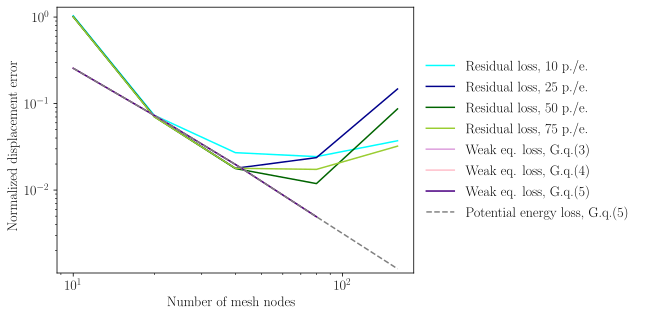

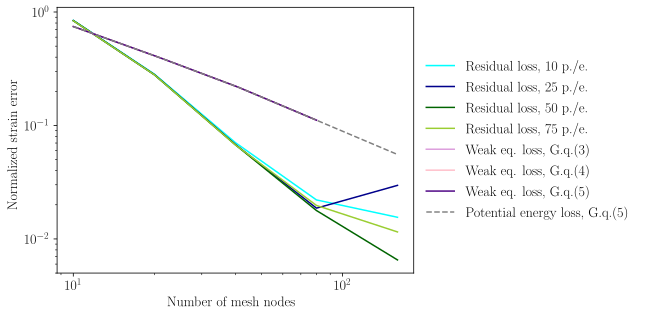

In [38]:
import matplotlib.pyplot as plt
import matplotlib

# Plot normalized displacement error

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

plt.plot(mesh_resolution_r, loss_u_r[:,0],'-', color = "cyan", label = 'Residual loss, 10 p./e.')
plt.plot(mesh_resolution_r, loss_u_r[:,1],'-', color = "darkblue", label = 'Residual loss, 25 p./e.')
plt.plot(mesh_resolution_r, loss_u_r[:,2],'-', color = "darkgreen", label = 'Residual loss, 50 p./e.')
plt.plot(mesh_resolution_r, loss_u_r[:,3],'-', color = "yellowgreen", label = 'Residual loss, 75 p./e.')

plt.plot(mesh_resolution_w, loss_u_w[:,0],'-', color = "plum", label = 'Weak eq. loss, G.q.(3)')
plt.plot(mesh_resolution_w, loss_u_w[:,1],'-', color = "pink", label = 'Weak eq. loss, G.q.(4)')
plt.plot(mesh_resolution_w, loss_u_w[:,1],'-', color = "indigo", label = 'Weak eq. loss, G.q.(5)')
plt.plot(mesh_resolution_pe, loss_u_pe,'--', color = "gray", label = 'Potential energy loss, G.q.(5)')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.0011, 1.3])

plt.xlabel("Number of mesh nodes")
plt.ylabel("Normalized displacement error")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False )

plt.show()

# Plot normalized strain error

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

plt.plot(mesh_resolution_r, loss_grad_r[:,0],'-', color = "cyan", label = 'Residual loss, 10 p./e.')
plt.plot(mesh_resolution_r, loss_grad_r[:,1],'-', color = "darkblue", label = 'Residual loss, 25 p./e.')
plt.plot(mesh_resolution_r, loss_grad_r[:,2],'-', color = "darkgreen", label = 'Residual loss, 50 p./e.')
plt.plot(mesh_resolution_r, loss_grad_r[:,3],'-', color = "yellowgreen", label = 'Residual loss, 75 p./e.')

plt.plot(mesh_resolution_w, loss_grad_w[:,0],'-', color = "plum", label = 'Weak eq. loss, G.q.(3)')
plt.plot(mesh_resolution_w, loss_grad_w[:,1],'-', color = "pink", label = 'Weak eq. loss, G.q.(4)')
plt.plot(mesh_resolution_w, loss_grad_w[:,1],'-', color = "indigo", label = 'Weak eq. loss, G.q.(5)')
plt.plot(mesh_resolution_pe, loss_grad_pe,'--', color = "gray", label = 'Potential energy loss, G.q.(5)')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.005, 1.1])

plt.xlabel("Number of mesh nodes")
plt.ylabel("Normalized strain error")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False )
plt.show()